In [1]:
use_gdrive = True # @param {type:"boolean"}

RESULTS_PATH = "results2"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab23/results2"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab_23' ] && git clone https://github.com/ethz-spylab/infoseclab_23.git
%cd infoseclab_23
!git pull https://github.com/ethz-spylab/infoseclab_23.git
%cd ..
if "infoseclab_23" not in sys.path:
  sys.path.append("infoseclab_23")

/content/infoseclab_23
From https://github.com/ethz-spylab/infoseclab_23
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


# Imports

In [3]:
import infoseclab
from infoseclab import ShadowModels, utils, evaluation
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import sklearn
import warnings
from zipfile import ZipFile

# Membership Inference

In this part of the lab, you will create a membership inference attack, with a twist:
you do not know which shadow models were trained on which samples.

First, load the predictions.

In [4]:
# Load data
activations_fit = ShadowModels.activations_fit        # pre-softmax activations from shadow models to construct your attack (50000 x 127 x 10)
activations_attack = ShadowModels.activations_attack  # pre-softmax activations from the target model to attack (50000 x 10)
labels = ShadowModels.labels                          # the class labels of all samples (50000)
training_splits = ShadowModels.training_splits        # train-test vector; -1 for test samples, 1/0 (member/non-member) for training samples (50000)

num_samples, num_models, num_classes = activations_fit.shape
assert activations_attack.shape == (num_samples, num_classes)
assert labels.shape == (num_samples,)
assert training_splits.shape == (num_samples,)

# Mask that is True for all samples with a known target membership label
training_mask = (training_splits != -1)


**Implement your membership inference attack in the following cell.**

Remember that your output should be a NumPy array
containing attack scores for *all* samples,
but we only consider samples where the corresponding `training_mask` entry
is `False` for grading.

The following code performs a dummy attack that ignores all shadow model outputs.

In [5]:
# Imports
import copy
import numpy as np
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [6]:
# Utils
row_indeces = np.arange(50000)
column_indeces = copy.deepcopy(labels)
IN_mask = np.where(training_splits == 1, True, False)
OUT_mask = np.where(training_splits == 0, True, False)

In [7]:
# Classes
# From Sci-kit Learn documentation
# covariance_type{'full', 'tied', 'diag', 'spherical'}, default='full'
# init_params{'kmeans', 'k-means++', 'random', 'random_from_data'}, default='kmeans'
class GaussianMixtureModel:
    def __init__(self, n_components=2, random_state=42, covariance_type='tied', init_params='k-means++'):
        self.n_components = n_components
        self.random_state = random_state
        self.covariance_type = covariance_type
        self.init_params = init_params
        self.model = None
        self.mmidx = None

    def fit(self, X):
        self.model = GaussianMixture(n_components=self.n_components, random_state=self.random_state,
                                     covariance_type=self.covariance_type, init_params=self.init_params).fit(X)
        self.mmidx = np.argmax(self.model.means_)
        return self

    def compute_likelihoods(self, X):
        likelihoods = list()
        for i in range(0, self.n_components):
            likelihood = norm.pdf(X, self.model.means_[i], np.sqrt(self.model.covariances_.item((0,0)))).flatten()
            likelihoods.append(likelihood)
        return likelihoods


class LikelihoodRatioCalculator:
    def __init__(self):
        self.likelihood_ratios = list()

    def calculate_ratio(self, likelihoods, mmidx):
        likelihood_ratio = likelihoods[mmidx] / (likelihoods[1 - mmidx] + 1e-10)
        self.likelihood_ratios.append(likelihood_ratio)

    def get_ratios(self):
        return np.array(self.likelihood_ratios)


class GaussianMixtureAnalyzer:
    def __init__(self, logit_scores_shadow, logit_scores_attack):
        self.logit_scores_shadow = logit_scores_shadow
        self.logit_scores_attack = logit_scores_attack
        self.gmm = GaussianMixtureModel()
        self.likelihood_ratio_calculator = LikelihoodRatioCalculator()

    def analyze(self):
        for i in range(0, self.logit_scores_shadow.shape[0]):
            self.gmm.fit(self.logit_scores_shadow[i, :].reshape(-1, 1))
            likelihoods = self.gmm.compute_likelihoods(self.logit_scores_attack[i])
            self.likelihood_ratio_calculator.calculate_ratio(likelihoods, self.gmm.mmidx)
        return self.likelihood_ratio_calculator.get_ratios()

In [8]:
# Functions
def target_logit_scale(activations, labels):
    z1 = activations[np.arange(activations.shape[0]), labels]
    z2 = activations.copy()
    z2[np.arange(activations.shape[0]), labels] = -np.inf
    logit_scores = z1 - logsumexp(z2, axis=1)
    return logit_scores


def fit_logit_scale(pre_softmax_activations, class_labels):
    samples, sequences, classes = pre_softmax_activations.shape
    broadcasted_labels = np.broadcast_to(class_labels[:, None], (samples, sequences))
    mask = np.ones_like(pre_softmax_activations, dtype=bool)
    mask[np.arange(samples)[:, None], np.arange(sequences), broadcasted_labels] = False
    modified_activations = np.where(mask, pre_softmax_activations, -np.inf)
    log_sum_exp = logsumexp(modified_activations, axis=2)
    target_class_activations = pre_softmax_activations[np.arange(samples)[:, None], np.arange(sequences), broadcasted_labels]
    logit_scores = target_class_activations - log_sum_exp
    return logit_scores


In [9]:
# Step1: Extracts the pre-softmax scores of the target class for each sample in the activations_attack array
activations_attack_target = activations_attack[row_indeces, column_indeces]

In [10]:
# Step2: Extract the pre-softmax scores for the IN and OUT samples
IN_activations_attack_target = activations_attack_target[IN_mask]
OUT_activations_attack_target = activations_attack_target[OUT_mask]

In [11]:
# Step3: Logit rescaling to facilitate the normal distribution fits
logit_scaled_activations_attack_target = target_logit_scale(activations_attack, labels)
logit_scaled_activations_fit = fit_logit_scale(activations_fit, labels)

In [13]:
# Step4: Compute the likelihood ratios
analyzer = GaussianMixtureAnalyzer(logit_scaled_activations_fit, logit_scaled_activations_attack_target)
likelihood_ratios = analyzer.analyze()

GMM Attack TPR @ FPR 1.00%: 12.29%


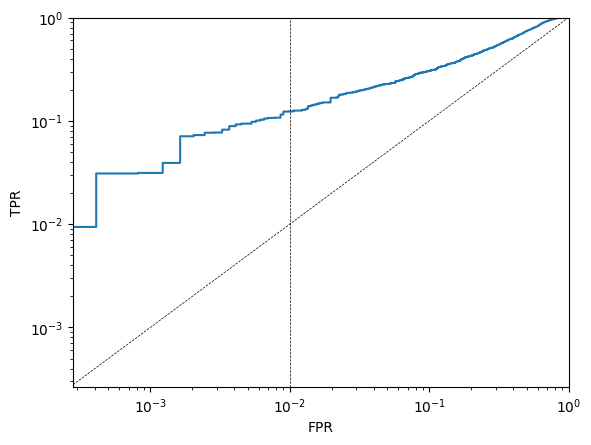

In [15]:
# Step5: Save and see the results
attack_scores = copy.deepcopy(likelihood_ratios.flatten()).astype(np.float32)
utils.save_attack_scores(os.path.join(RESULTS_PATH, "attack_scores.npy"), attack_scores)

fig, ax = plt.subplots()
evaluation.eval_mia(
    true_splits=training_splits[training_mask],
    attack_scores=attack_scores[training_mask],
    ax=ax,
    label="GMM Attack",
    plot_decorations=True,
)
plt.show(fig)
plt.close(fig)

# Stealing Chatbot Prompts

Enter results for the chatbot secret extraction

In [16]:
# Enter your 10 extracted secrets, 6 alphanumeric characters each
secrets = [
    "TIOsxG",
    "ur71Ct",
    "x7yQxM",
    "3PiGUk",
    "TZoP2i",
    "NofQK8",
    "6gTiO0",
    "pss410",
    "j7xE6h",
    "hmaPiB"
]

# save the secrets to an array and save it to chatbot.npy
secrets = np.array(secrets)
assert len(secrets) == 10
np.save(f"{RESULTS_PATH}/chatbot.npy", secrets)

# Create submission file (**upload `results2.zip` to moodle**)

In [17]:
!zip -j -FSr "{RESULTS_PATH}/results2.zip" {RESULTS_PATH}

  adding: attack_scores.npy (deflated 27%)
  adding: chatbot.npy (deflated 52%)


In [18]:
from infoseclab.submission import validate_zip2
assert validate_zip2(f"{RESULTS_PATH}/results2.zip")

Zip file is valid
